In [1]:
%run utils.py
%matplotlib inline
import os.path as osp
import pandas as pd
import numpy as np
import tqdm
import mygene

In [2]:
mg = mygene.MyGeneInfo()

In [3]:
df_pr = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstract_proteins_resolved.csv'))
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61064 entries, 0 to 61063
Data columns (total 8 columns):
id            61064 non-null int64
start         61064 non-null int64
end           61064 non-null int64
value         61064 non-null object
class         61064 non-null object
value_norm    61064 non-null object
value_lbl     61064 non-null object
value_sym     17341 non-null object
dtypes: int64(3), object(5)
memory usage: 3.7+ MB


In [4]:
# Use normalized raw value instead of HGNC-resolved value_lbl
qfld = 'value_norm'

## Build Queries

In [5]:
from unidecode import unidecode

def normalize_to_query(pr):
    # Normalize greeks and super/subscripts (TNFα -> TNFa, CX₃CR1 -> CX3CR1)
    # Quotes and ticks will result bad http requests
    return unidecode(pr).replace("'", "").replace('"', '')

df_query = pd.DataFrame([
    {'query': normalize_to_query(pr), qfld: pr}
    for pr in df_pr[qfld].unique()
])
df_query.head()

,query,value_norm
0,FCGRIIB,FCGRIIB
1,IL2,IL2
2,FOXP3,FOXP3
3,CD4,CD4
4,TCR,TCR


In [6]:
# Show proteins that normalized to the same query terms (which isn't a problem)
cts = df_query.groupby('query').size()
df_query[df_query['query'].isin(cts[cts > 1].index.values)].sort_values('query')

,query,value_norm


In [7]:
batch_size = 250
q_pr = df_query['query'].unique()
q_pr_n = len(q_pr)
q_pr = np.array_split(q_pr, q_pr_n//batch_size)
print(
    'Number of queries total = {}\nNumber of query batches = {}\nBatch size counts:\n{}'
    .format(q_pr_n, len(q_pr), pd.Series([len(b) for b in q_pr]).value_counts())
)

Number of queries total = 5165
Number of query batches = 20
Batch size counts:
258    15
259     5
dtype: int64


## Run Queries

In [8]:
# See full list: http://docs.mygene.info/en/latest/doc/data.html#species
SPECIES = {9606: 'human', 10090: 'mouse'}

def query(terms):
    df = mg.querymany(
        terms,
        scopes=["symbol", "retired", "name", "alias"],
        fields='symbol,name,taxid,ensembl.gene,alias', 
        species='human,mouse', 
        ensemblonly=True,
        as_dataframe=True
    )
    if 'taxid' in df:
        df['species'] = df['taxid'].apply(lambda v: None if pd.isnull(v) else SPECIES.get(int(v), 'unknown'))
    return df

df_res = []
for batch in tqdm.tqdm(q_pr):
    df_res.append(query(list(batch)))
    
df_res = pd.concat(df_res)

  0%|          | 0/20 [00:00<?, ?it/s]

querying 1-259...done.


  5%|▌         | 1/20 [00:02<00:42,  2.24s/it]

Finished.
149 input query terms found dup hits:
	[('IL2', 4), ('FOXP3', 5), ('CD4', 10), ('TCR', 4), ('SATB1', 4), ('CD14', 3), ('HLA', 10), ('PD1', 
103 input query terms found no hit:
	['FCGRIIB', 'PROGRAMMEDDEATH1', 'TFH2', 'TFH17', 'TFH1', 'LGLS', 'MHCI', 'APRCA', 'IMMUNOGLOBULING2A
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-259...done.


 10%|█         | 2/20 [00:05<00:44,  2.46s/it]

Finished.
98 input query terms found dup hits:
	[('TF', 10), ('AKT', 10), ('GARP', 10), ('CD73', 2), ('TCRA', 6), ('TCRB', 10), ('GMCSF', 2), ('INOS
144 input query terms found no hit:
	['WB', 'HUT102', 'IFC', 'HIV1', 'GRANU', 'GROWTHFACTOR', 'ADGM', 'TARGET6', 'ESAT6', 'RV0753C', 'RV0
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-259...done.


 15%|█▌        | 3/20 [00:08<00:45,  2.70s/it]

Finished.
99 input query terms found dup hits:
	[('SEMA3A', 2), ('REGULATOR', 10), ('CD24', 9), ('CD27', 3), ('MDA5', 2), ('STAT1', 2), ('IL27', 3),
147 input query terms found no hit:
	['SEMAPHORIN3A', 'SEMAPHORINS', 'RIGILIKE', 'RLR', 'CHB', 'CD4AND', 'TGM', 'COMPLEMENTCONTROLPROTEIN
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-259...done.


 20%|██        | 4/20 [00:10<00:39,  2.48s/it]

Finished.
92 input query terms found dup hits:
	[('SYK', 2), ('MYD88', 2), ('P38', 10), ('JNK', 2), ('SUPER', 4), ('HDAC', 4), ('HDAC6', 2), ('HISTO
154 input query terms found no hit:
	['IMMUNOGLOBULING1', 'IL4HS2', 'IL4CNS2', 'OROXYLINA', 'SMAD3P', 'P38P', 'JNKP', 'ERK12', 'TPATH2', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-259...done.


 25%|██▌       | 5/20 [00:12<00:34,  2.33s/it]

Finished.
100 input query terms found dup hits:
	[('PSA', 8), ('GONADOTROPIN', 10), ('HCG', 5), ('FOLR4', 2), ('ITGB8', 2), ('PGLYRP1', 2), ('IL1RL1'
143 input query terms found no hit:
	['STAT3BASED', 'TYPEIICOLLAGEN', 'COLLAGENII', 'HUMANCHORIONICGONADOTROPIN', 'GALECTIN10', 'EOE', 'I
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 30%|███       | 6/20 [00:14<00:33,  2.39s/it]

Finished.
77 input query terms found dup hits:
	[('EXO', 4), ('3P', 5), ('B1', 10), ('CB', 2), ('MOG', 2), ('CD47', 2), ('GITRL', 2), ('QA1', 3), ('
166 input query terms found no hit:
	['MIR243P', 'CD11CMHC', 'CD11CLANGERINMHC', 'TYPE1', 'CANNABINOID1AND2', 'AEA', 'RORGTFACTOR', 'GLUC
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 35%|███▌      | 7/20 [00:18<00:33,  2.59s/it]

Finished.
90 input query terms found dup hits:
	[('RAI', 5), ('CD134', 2), ('CD134L', 2), ('TNFRSF4', 2), ('TNFSF4', 2), ('SIT', 2), ('CD152', 2), (
144 input query terms found no hit:
	['OX40OX40L', 'BOXPROTEINP3', 'TRECS', 'SIRT1MTOR', 'RUNTRELATEDTRANSCRIPTIONFACTOR3', 'RUNTDOMAIN',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 40%|████      | 8/20 [00:20<00:29,  2.46s/it]

Finished.
72 input query terms found dup hits:
	[('LTBR', 2), ('LYMPHOTOXIN', 6), ('CEBPB', 4), ('ITK', 2), ('MST1', 4), ('DRB1', 4), ('JAK2', 2), (
170 input query terms found no hit:
	['LUCIFERASE', 'TLTS', 'LYMPHOTOXINAB', 'LTAB', 'PHOSPHOSTAT5', 'BINDINGPROTEIN', 'IL6C', 'KINASEITK
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 45%|████▌     | 9/20 [00:22<00:25,  2.36s/it]

Finished.
94 input query terms found dup hits:
	[('NFAT1', 2), ('NFAT2', 2), ('NFATC2', 2), ('NFATC1', 2), ('P53', 10), ('KIR3DL2', 2), ('TPC', 3), 
147 input query terms found no hit:
	['RAPAMYCIN1', 'MTOR1', 'DOGMA', 'DNTGFBRII', 'AGALCER', 'MYELINASSOCIATEDAGS', 'NFAT1CD4', 'DIOXINL
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 50%|█████     | 10/20 [00:25<00:25,  2.53s/it]

Finished.
73 input query terms found dup hits:
	[('PLT', 2), ('ECTO', 8), ('MBP', 5), ('IFNAR1', 2), ('ACC1', 3), ('MALT1', 2), ('PARACASPASE', 2), 
166 input query terms found no hit:
	['CLASSIBMAJORHISTOCOMPATIBILITY', 'FOXP3MRNA', 'SCCS', 'FOXP3EXPRESSION', 'ACETYLCOACARBOXYLASE1', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 55%|█████▌    | 11/20 [00:28<00:24,  2.68s/it]

Finished.
67 input query terms found dup hits:
	[('CAMK4', 2), ('TYROSINASE', 9), ('LPL', 3), ('RAG2', 2), ('IA', 9), ('CDM', 3), ('MUC4', 2), ('IRA
177 input query terms found no hit:
	['CTLA4PKCE', 'GIT2APIX', 'CAMK4DEPENDENT', 'CREMA', 'CALCIUMCALMODULINDEPENDENTPROTEINKINASEIV', 'C
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 60%|██████    | 12/20 [00:30<00:19,  2.49s/it]

Finished.
81 input query terms found dup hits:
	[('CHAPERONE', 10), ('HSF1', 2), ('HSP70', 10), ('HBZ', 2), ('BST2', 3), ('ISG15', 2), ('OAS2', 2), 
165 input query terms found no hit:
	['SHOCKFACTOR1', '17AAG', 'ALLERGENSIT', 'HTLV1', 'BASICLEUCINEZIPPERFACTOR', 'AVPS', 'NTERMINALKINA
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 65%|██████▌   | 13/20 [00:32<00:16,  2.38s/it]

Finished.
65 input query terms found dup hits:
	[('VEGFR2', 2), ('SLAMF1', 2), ('CD205', 3), ('ISLET', 10), ('GAPDH', 3), ('ZBTB16', 2), ('POLYMORPH
179 input query terms found no hit:
	['PEIFNGA2B', 'OESTROGEN', 'BCLXL', 'TKI', 'VEGFRS', 'SIGAD', 'IDCM', 'CLASSIORCLASSIIHLA', 'PLATELE
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 70%|███████   | 14/20 [00:34<00:13,  2.23s/it]

Finished.
63 input query terms found dup hits:
	[('CELLS', 10), ('IRX2', 2), ('MANNOSE', 10), ('TICAM1', 2), ('TRIF', 6), ('CDK6', 2), ('CD59', 2), 
179 input query terms found no hit:
	['EAHL', 'CD8086DEPENDENT', '86', 'TCCR7', 'TNFRELATEDAPOPTOSISINDUCING', 'GZMBPROGRAMMEDDEATH12', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 75%|███████▌  | 15/20 [00:37<00:12,  2.52s/it]

Finished.
57 input query terms found dup hits:
	[('VAP1', 2), ('CLIP', 7), ('PRB', 2), ('GDA', 5), ('NOS2', 6), ('PGD2', 3), ('SLIT', 10), ('IGVH', 
183 input query terms found no hit:
	['FEEL1', 'STABILIN1', 'VASCULARADHESIONPROTEIN1', 'ASSOCIATEDINVARIANTCHAIN', 'ASSOCIATEDINVARIANTC
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 80%|████████  | 16/20 [00:39<00:09,  2.36s/it]

Finished.
47 input query terms found dup hits:
	[('MKI67', 10), ('MAJOR', 10), ('TIEG1', 2), ('DESMOGLEIN', 10), ('MIR223', 3), ('POLYMERASE', 10), 
196 input query terms found no hit:
	['FCRL3T', 'PROTEIN1A', 'GRANULOCYTECHEMOTACTICPROTEIN2', 'C57BL6', 'BCELLACTIVATINGFACTOROFTHETNF',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 85%|████████▌ | 17/20 [00:41<00:06,  2.21s/it]

Finished.
57 input query terms found dup hits:
	[('SLAM', 10), ('TGFA', 4), ('PLCG2', 2), ('P28', 8), ('HY', 2), ('NFATC', 2), ('CD29', 2), ('CD212'
180 input query terms found no hit:
	['SIGNALLINGLYMPHOCYTICACTIVATIONMOLECULE', 'IFNGANDTYPE2', 'CLTA4', 'OFTH2', 'SCD30', 'CD11CBDCA1',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 90%|█████████ | 18/20 [00:43<00:04,  2.11s/it]

Finished.
57 input query terms found dup hits:
	[('VLA1', 2), ('RD6', 2), ('JANUS', 10), ('SPRED1', 2), ('RELAXIN', 10), ('VA', 5), ('DAP10', 2), ('
189 input query terms found no hit:
	['TREGULATORYCELLTYPE', 'ANGIOGENICGROWTHFACTOR', 'HPV16E6', 'ESCC', 'ME6D', 'ME7', 'TBHSP70D', 'BET
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


 95%|█████████▌| 19/20 [00:45<00:02,  2.25s/it]

Finished.
60 input query terms found dup hits:
	[('A21', 6), ('IFNB1', 2), ('MCP3', 2), ('MIP3B', 2), ('AB1', 4), ('PDE4B', 2), ('PDE4A', 2), ('H1R'
184 input query terms found no hit:
	['HTYR', 'MTYR', 'NONSELF', 'CTLASSOCIATEDAG4', 'CD3SFV', 'ALLERGENANDRECALL', 'LAGE1', 'DRB10401', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-258...done.


100%|██████████| 20/20 [00:48<00:00,  2.50s/it]

Finished.
44 input query terms found dup hits:
	[('CARDIOLIPIN', 2), ('ID', 8), ('ABPA', 2), ('JUN', 10), ('NKRP1A', 2), ('CAK', 4), ('PHOSPHODIESTE
192 input query terms found no hit:
	['BSAB', 'THROMBOPLASTIN', 'APTT', 'P38AMITOGENACTIVATEDPROTEINKINASE', 'GGLOBULIN', 'DHGG', 'THELPE
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [9]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10216 entries, FCGRIIB to CYA
Data columns (total 10 columns):
_id             6908 non-null object
_score          6908 non-null float64
alias           5813 non-null object
ensembl         244 non-null object
ensembl.gene    5575 non-null object
name            6908 non-null object
notfound        3308 non-null object
symbol          6908 non-null object
taxid           6908 non-null float64
species         6908 non-null object
dtypes: float64(2), object(8)
memory usage: 877.9+ KB


In [10]:
df_res.head()

,_id,_score,alias,ensembl,ensembl.gene,name,notfound,symbol,taxid,species
query,,,,,,,,,,
FCGRIIB,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,None
IL2,3558,91.855820,"[IL-2, TCGF, lymphokine]",NaN,ENSG00000109471,interleukin 2,NaN,IL2,9606.0,human
IL2,16183,76.127144,Il-2,NaN,ENSMUSG00000027720,interleukin 2,NaN,Il2,10090.0,mouse
IL2,3702,12.199604,"[EMT, LPFS1, LYK, PSCTK2]",NaN,ENSG00000113263,IL2 inducible T cell kinase,NaN,ITK,9606.0,human
IL2,16428,10.449790,"[Emt, Tcsk, Tsk]",NaN,ENSMUSG00000020395,IL2 inducible T cell kinase,NaN,Itk,10090.0,mouse


In [11]:
df_qlkp = df_query.set_index('query')
df_qlkp.index.is_unique

True

In [12]:
df_qlkp.head()

,value_norm
query,
FCGRIIB,FCGRIIB
IL2,IL2
FOXP3,FOXP3
CD4,CD4
TCR,TCR


In [13]:
# Merge results by query string back to query frame containing original protein symbol
df_res_pr = pd.merge(
    df_res.reset_index(), 
    df_qlkp.reset_index(),
    on='query',
    how='left'
)

# Reorganize some field names
df_res_pr = df_res_pr.rename(columns={
    '_id': 'id', 
    '_score': 'score', 
    'ensembl.gene': 'ensemblgene',
    'symbol': 'sym'
})

# Remove results with no match
df_res_pr = df_res_pr[df_res_pr['id'].notnull()]
df_res_pr = df_res_pr[['id', 'score', 'sym', 'name', 'ensemblgene', 'species', qfld]]

df_res_pr['ensemblgene'] = df_res_pr['ensemblgene'].str.strip()

# Ensure that remaining records all have a reference to pubmed protein name
assert df_res_pr[qfld].notnull().all()

df_res_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6908 entries, 1 to 10214
Data columns (total 7 columns):
id             6908 non-null object
score          6908 non-null float64
sym            6908 non-null object
name           6908 non-null object
ensemblgene    5575 non-null object
species        6908 non-null object
value_norm     6908 non-null object
dtypes: float64(1), object(6)
memory usage: 431.8+ KB


In [14]:
df_res_pr.head()

,id,score,sym,name,ensemblgene,species,value_norm
1,3558,91.855820,IL2,interleukin 2,ENSG00000109471,human,IL2
2,16183,76.127144,Il2,interleukin 2,ENSMUSG00000027720,mouse,IL2
3,3702,12.199604,ITK,IL2 inducible T cell kinase,ENSG00000113263,human,IL2
4,16428,10.449790,Itk,IL2 inducible T cell kinase,ENSMUSG00000020395,mouse,IL2
5,50943,87.493290,FOXP3,forkhead box P3,ENSG00000049768,human,FOXP3


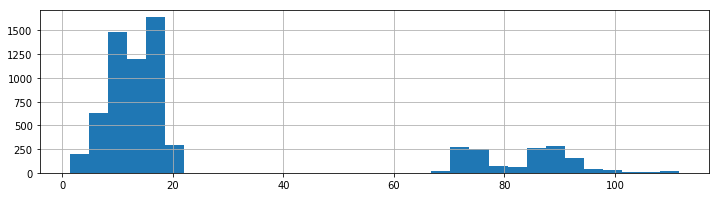

In [15]:
df_res_pr['score'].hist(bins=32, figsize=(12, 3))

In [16]:
# Validate that all species results were resolved
assert df_res_pr['species'].isin(SPECIES.values()).all()
df_res_pr['species'].value_counts()

human    4125
mouse    2783
Name: species, dtype: int64

## Add transcription factor flag

In [17]:
# This is small enough that it doesn't need a separate annotation notebook
df_tf = pd.read_csv(osp.join(DATA_DIR, 'human_tfs.csv'))
df_tf['ensemblid'] = df_tf['ensemblid'].str.strip()
df_res_pr['is_tf'] = df_res_pr['ensemblgene'].isin(df_tf['ensemblid'].unique())
df_res_pr['is_tf'].value_counts()

False    6582
True      326
Name: is_tf, dtype: int64

## Export

In [18]:
# For consistency with other annotation notebooks, prefix field originating
# from pubmed protein table
df_exp = df_res_pr.rename(columns={qfld: 'pr_' + qfld})
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6908 entries, 1 to 10214
Data columns (total 8 columns):
id               6908 non-null object
score            6908 non-null float64
sym              6908 non-null object
name             6908 non-null object
ensemblgene      5575 non-null object
species          6908 non-null object
pr_value_norm    6908 non-null object
is_tf            6908 non-null bool
dtypes: bool(1), float64(1), object(6)
memory usage: 438.5+ KB


In [20]:
path = osp.join(DATA_DIR, 'pubmed_mygene_protein_annotations.csv')
df_exp.to_csv(path, index=False)
path

'data/pubmed_mygene_protein_annotations.csv'